In [1]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

Great, we now have a way of exploring different questions to observe the split and size of clusters that we can run through our GNN. Lets now once again deal with cohesion as a whole using all 26 questions to classify acceptable annotations. We will reconsider our methods for the scoring of agreeability, and instead replicate what was done in Hayley Hung's study. This involves doing the following: 

1. Identifying the valence of different question scoring's and realliging these scorings, such that for all 26 questions high scores are indicative of high cohesion (as opposed to having questions for which low scores are indicative of high cohesion). 
2. We will compute a Weighted Kappa score using Linear decay. 
3. Plotting the mean weighted Kappa versus the mean score for each group of annotations and, following the study as a reference, drawing a high and low cohesion group from annotation groups with a mean weighted kappa score greater than 0.3. Hopefully we see te same manifold. 

Lets start by creating a new data frame from where the data has not been imputed, split, or adjusted in any way.  

In [90]:
# Define the directory containing the annotation files
annotations_dir = '/Users/manuelnunezmartinez/Documents/UF/Research Internship/code/Cohesion_Annotations/CohesionAnnotations'

# List all files in the directory
files = [f for f in os.listdir(annotations_dir) if f.endswith('.txt')]

# Function to parse a filename and extract meeting, start, and end times
def parse_filename(filename):
    parts = filename.split('_')
    meeting = parts[0]
    start = float(parts[1])
    end = float(parts[2])
    return meeting, start, end

# Initialize a dictionary to store the dataset rows grouped by 'Meeting', 'Start', and 'End'
grouped_data = defaultdict(list)

# Read and process each file
for file in files:
    meeting, start, end = parse_filename(file)
    filepath = os.path.join(annotations_dir, file)
    
    with open(filepath, 'r') as f:
        scores = [line.strip() for line in f.readlines() if line.strip()]  # Remove empty lines
    
    # Read only the first 27 lines and convert them to integers
    scores = scores[:27]  # Ensure we only keep the first 27 lines
    
    # Group by 'Meeting', 'Start', and 'End' and append the cohesion scores to the existing entry
    grouped_data[(meeting, start, end)].append(scores)

# Create a list to store the combined data
combined_data = []

# Combine the rows for each unique 'Meeting', 'Start', 'End'
for (meeting, start, end), cohesion_lists in grouped_data.items():
    combined_cohesion = cohesion_lists  # This will be a 2D list containing all the cohesion scores for that group
    combined_data.append([meeting, start, end, combined_cohesion])

# Convert the combined data to a DataFrame
df_cohesion = pd.DataFrame(combined_data, columns=['Meeting', 'Start', 'End', 'Cohesion'])

# Show the combined DataFrame
df_cohesion.head()


,Meeting,Start,End,Cohesion
0,IS1006d,25.0,27.0,"[[3, 4, 4, 3, 3, 6, 5, 4, 3, 2, -1, 7, 5, 2, 6..."
1,IS1007b,1.0,3.0,"[[3, 6, -1, 2, 6, 3, 6, 1, 6, 1, 7, 5, 2, 6, 1..."
2,IS1003c,23.0,25.0,"[[2, 3, 5, 3, 5, 4, 6, 2, 4, 2, -1, 3, 5, 5, 3..."
3,IS1005c,8.0,10.0,"[[5, 5, 3, 4, 4, 4, 5, 3, 4, 1, 7, 3, 3, 4, 1,..."
4,IS1001a,7.0,9.0,"[[3, 6, 5, 2, 4, 4, 6, 2, 6, 1, 3, 6, 4, 4, 2,..."


In [91]:
# Function to convert all entries in a 2D list to floats
def convert_to_float(cohesion_lists):
    return [[float(value) for value in sublist] for sublist in cohesion_lists]

# Apply the conversion to the 'Cohesion' column
df_cohesion['Cohesion'] = df_cohesion['Cohesion'].apply(convert_to_float)

# Show the updated DataFrame
df_cohesion.head()

,Meeting,Start,End,Cohesion
0,IS1006d,25.0,27.0,"[[3.0, 4.0, 4.0, 3.0, 3.0, 6.0, 5.0, 4.0, 3.0,..."
1,IS1007b,1.0,3.0,"[[3.0, 6.0, -1.0, 2.0, 6.0, 3.0, 6.0, 1.0, 6.0..."
2,IS1003c,23.0,25.0,"[[2.0, 3.0, 5.0, 3.0, 5.0, 4.0, 6.0, 2.0, 4.0,..."
3,IS1005c,8.0,10.0,"[[5.0, 5.0, 3.0, 4.0, 4.0, 4.0, 5.0, 3.0, 4.0,..."
4,IS1001a,7.0,9.0,"[[3.0, 6.0, 5.0, 2.0, 4.0, 4.0, 6.0, 2.0, 6.0,..."


 Lets first replicate their PCA to see if we get similar results. We start by falttening all scores into one long list. 

In [92]:
# Flatten each entry in the 'Cohesion' column but maintain the list structure for each entry
annotations = [list(item) for sublist in df_cohesion['Cohesion'] for item in sublist]
print(annotations[0])

[3.0, 4.0, 4.0, 3.0, 3.0, 6.0, 5.0, 4.0, 3.0, 2.0, -1.0, 7.0, 5.0, 2.0, 6.0, 3.0, 5.0, 3.0, 3.0, 6.0, 3.0, 1.0, 3.0, 5.0, 5.0, 2.0, 7.0]


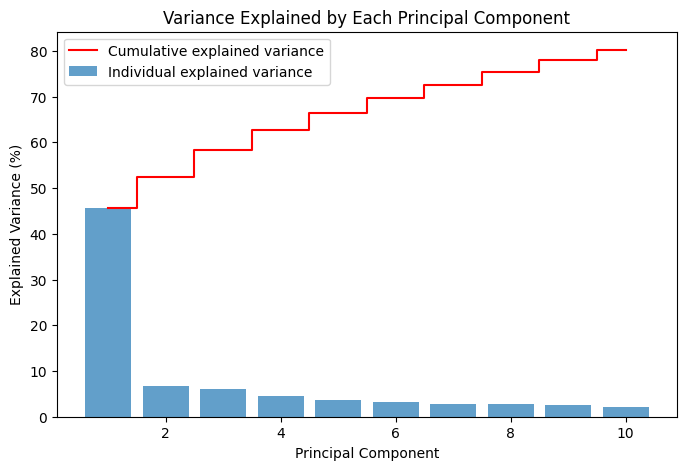

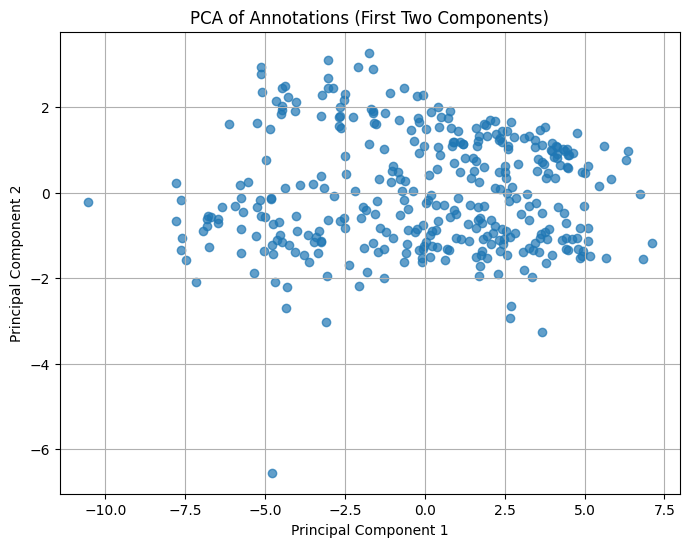

In [93]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Convert the list of annotations into a matrix (rows: samples, columns: questions)
annotations_matrix = np.array(annotations)

# Step 2: Standardize the data
scaler = StandardScaler()
annotations_scaled = scaler.fit_transform(annotations_matrix)

# Step 3: Apply PCA
pca = PCA(n_components=10)  # Keep 2 components for now to visualize
principal_components = pca.fit_transform(annotations_scaled)

# Step 4: Plot the explained variance (Eigenvalues) for each component
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

# Plot the explained variance for each component
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance * 100, alpha=0.7, label='Individual explained variance')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance * 100, where='mid', label='Cumulative explained variance', color='red')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('Variance Explained by Each Principal Component')
plt.legend(loc='best')
plt.show()

# Step 5: Visualize the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Annotations (First Two Components)')
plt.grid(True)
plt.show()

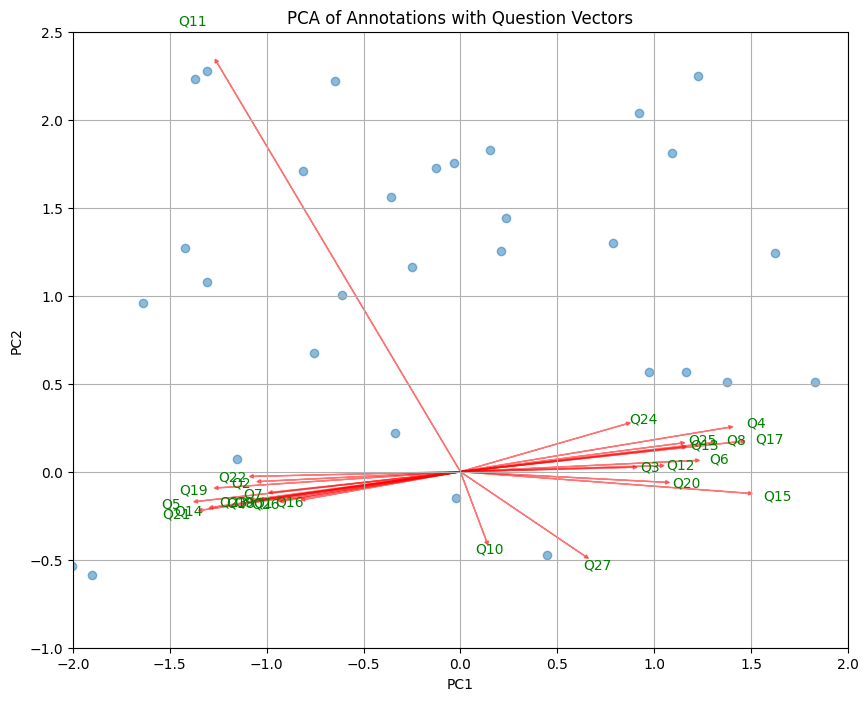

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming `annotations` is your list of lists (27 integers each)

# Convert the annotations list to a DataFrame
annotations_df = pd.DataFrame(annotations)

# Perform PCA
pca = PCA(n_components=2)  # Only take the first two components for plotting
pca_result = pca.fit_transform(annotations_df)

# Get the loadings (these represent the "weights" of each original variable in the PCA components)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Create the PCA plot with data points
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Annotations with Question Vectors')

# Add vectors for each question (variable) and label them
for i, (x, y) in enumerate(loadings):
    plt.arrow(0, 0, x, y, color='r', alpha=0.5, head_width=0.02, head_length=0.02)
    plt.text(x * 1.1, y * 1.1, f'Q{i+1}', color='g', ha='center', va='center')

# Zoom in around the origin by setting axis limits
plt.xlim(-2, 2)  # Adjust these limits as necessary
plt.ylim(-1, 2.5)  # Adjust these limits as necessary

# Add grid and show plot
plt.grid(True)
plt.show()


Okay, we have now obtained the same PCA results. The second graph which outputs vectors for each qeustion, is indicative of the valence of each question's scoring scale. We must now allign these valences. We will choose to correct Group 1 as these questions corrrelate low scores wit high coheison. 

Okay, I have figured out the discrepancy in th edata that was making me obtain bad results. In short, question 10 is a 2 part question, such that it is actually answers 10 and 11 that represent it. Additonally, a -1 means that no answr was chosen, so we will not impute data and instead compute all important metrics ignoring -1's.


Okay, lets now move onto the valence allignment

In [95]:
invert_indices = [1, 2, 5, 7, 9, 11, 14, 16, 18, 19, 21, 22, 23, 26]
invert_indices = [i - 1 for i in invert_indices]  

# Function to invert specific indices in the list
def invert_values(cohesion_list):
    return [8 - val if i in invert_indices else val for i, val in enumerate(cohesion_list)]

# Apply the inversion function to each entry in the 'Cohesion' column
df_cohesion['Cohesion'] = df_cohesion['Cohesion'].apply(lambda x: [invert_values(sublist) for sublist in x])

df_cohesion.head()

,Meeting,Start,End,Cohesion
0,IS1006d,25.0,27.0,"[[5.0, 4.0, 4.0, 3.0, 5.0, 6.0, 3.0, 4.0, 5.0,..."
1,IS1007b,1.0,3.0,"[[5.0, 2.0, -1.0, 2.0, 2.0, 3.0, 2.0, 1.0, 2.0..."
2,IS1003c,23.0,25.0,"[[6.0, 5.0, 5.0, 3.0, 3.0, 4.0, 2.0, 2.0, 4.0,..."
3,IS1005c,8.0,10.0,"[[3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 4.0,..."
4,IS1001a,7.0,9.0,"[[5.0, 2.0, 5.0, 2.0, 4.0, 4.0, 2.0, 2.0, 2.0,..."


Ok great, I now have all valence values alligned and only scores for relevant questions that I will use to find kappa values. I iwll now create Social and task cohesion columns to obtain kappa metrics from as well. 


In [96]:
# Define the question numbers for task, social, and miscellaneous cohesion
task_cohesion_numbers = [2, 3, 4, 7, 8, 19, 27]
social_cohesion_numbers = [1, 5, 6, 9, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26]
miscellaneous_numbers = [10, 11, 14]

# Convert to zero-based indices
task_cohesion_indices = [i - 1 for i in task_cohesion_numbers]  
social_cohesion_indices = [i - 1 for i in social_cohesion_numbers]
miscellaneous_indices = [i - 1 for i in miscellaneous_numbers]

# Function to extract specific indices for task, social, and miscellaneous
def extract_cohesion_values(cohesion_list, indices):
    return [cohesion_list[i] for i in indices]

# Create new columns for task, social, and miscellaneous cohesion
df_cohesion['Task_Cohesion'] = df_cohesion['Cohesion'].apply(lambda x: [extract_cohesion_values(sublist, task_cohesion_indices) for sublist in x])
df_cohesion['Social_Cohesion'] = df_cohesion['Cohesion'].apply(lambda x: [extract_cohesion_values(sublist, social_cohesion_indices) for sublist in x])
df_cohesion['Miscellaneous_Cohesion'] = df_cohesion['Cohesion'].apply(lambda x: [extract_cohesion_values(sublist, miscellaneous_indices) for sublist in x])

# Show the updated DataFrame
df_cohesion.head()


,Meeting,Start,End,Cohesion,Task_Cohesion,Social_Cohesion,Miscellaneous_Cohesion
0,IS1006d,25.0,27.0,"[[5.0, 4.0, 4.0, 3.0, 5.0, 6.0, 3.0, 4.0, 5.0,...","[[4.0, 4.0, 3.0, 3.0, 4.0, 5.0, 7.0], [1.0, 2....","[[5.0, 5.0, 6.0, 5.0, 7.0, 5.0, 6.0, 5.0, 5.0,...","[[2.0, 9.0, 6.0], [2.0, 9.0, 3.0], [2.0, 9.0, ..."
1,IS1007b,1.0,3.0,"[[5.0, 2.0, -1.0, 2.0, 2.0, 3.0, 2.0, 1.0, 2.0...","[[2.0, -1.0, 2.0, 2.0, 1.0, 5.0, 7.0], [4.0, 4...","[[5.0, 2.0, 3.0, 2.0, 5.0, 2.0, 1.0, 9.0, 2.0,...","[[1.0, 1.0, 2.0], [1.0, 3.0, 2.0], [2.0, 9.0, ..."
2,IS1003c,23.0,25.0,"[[6.0, 5.0, 5.0, 3.0, 3.0, 4.0, 2.0, 2.0, 4.0,...","[[5.0, 5.0, 3.0, 2.0, 2.0, 5.0, 6.0], [2.0, 3....","[[6.0, 3.0, 4.0, 4.0, 3.0, 5.0, 3.0, 3.0, 4.0,...","[[2.0, 9.0, 3.0], [2.0, 9.0, 2.0], [1.0, 9.0, ..."
3,IS1005c,8.0,10.0,"[[3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 4.0,...","[[3.0, 3.0, 4.0, 3.0, 3.0, 1.0, 1.0], [2.0, -1...","[[3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 1.0, 5.0, 2.0,...","[[1.0, 1.0, 4.0], [1.0, 9.0, 9.0], [1.0, 5.0, ..."
4,IS1001a,7.0,9.0,"[[5.0, 2.0, 5.0, 2.0, 4.0, 4.0, 2.0, 2.0, 2.0,...","[[2.0, 5.0, 2.0, 2.0, 2.0, 3.0, 3.0], [4.0, 5....","[[5.0, 4.0, 4.0, 2.0, 6.0, 4.0, 2.0, 5.0, 3.0,...","[[1.0, 5.0, 4.0], [1.0, 4.0, 1.0], [1.0, 4.0, ..."


Lets make a copy of this df to create another df later that will seperate annotations on a per question basis. 

In [97]:
questions_split_df = df_cohesion.copy()

lets now remove all misc indexes from the general cohesion column. 

    
Calculate the weighted Cohen's Kappa score for a single entry in the 'Cohesion', "Task" and 'Social' column.


In [98]:
from sklearn.metrics import cohen_kappa_score

def average_kappa(entry):
    """
    Calculate a weighted average Cohen's Kappa score for all pairs of annotators.
    Apply additional weights based on question importance.
    """
    annotator_1 = np.array(entry[0])
    annotator_2 = np.array(entry[1])
    annotator_3 = np.array(entry[2])

    labels = list(range(1, 8))  

    # Calculate kappa scores for all annotator pairs for each question
    kappa_12 = cohen_kappa_score(annotator_1, annotator_2, labels=labels, weights='quadratic')
    kappa_13 = cohen_kappa_score(annotator_1, annotator_3, labels=labels, weights='quadratic')
    kappa_23 = cohen_kappa_score(annotator_2, annotator_3, labels=labels, weights='quadratic')

    # Return the weighted average of the three Kappa scores
    return np.mean([kappa_12, kappa_13, kappa_23])



def apply_weighted_kappa(df):
    # Iterate over the dataframe and calculate the weighted average kappa
    df['Task_Kappa'] = df['Task_Cohesion'].apply(lambda entry: average_kappa(entry))
    df['Social_Kappa'] = df['Social_Cohesion'].apply(lambda entry: average_kappa(entry))
    df['Cohesion_Kappa'] = df['Cohesion'].apply(lambda entry: average_kappa(entry))
    return df


kappa_cohesion_df = apply_weighted_kappa(df_cohesion)


In [99]:
kappa_cohesion_df.head()

,Meeting,Start,End,Cohesion,Task_Cohesion,Social_Cohesion,Miscellaneous_Cohesion,Task_Kappa,Social_Kappa,Cohesion_Kappa
0,IS1006d,25.0,27.0,"[[5.0, 4.0, 4.0, 3.0, 5.0, 6.0, 3.0, 4.0, 5.0,...","[[4.0, 4.0, 3.0, 3.0, 4.0, 5.0, 7.0], [1.0, 2....","[[5.0, 5.0, 6.0, 5.0, 7.0, 5.0, 6.0, 5.0, 5.0,...","[[2.0, 9.0, 6.0], [2.0, 9.0, 3.0], [2.0, 9.0, ...",0.033335,0.140622,0.298247
1,IS1007b,1.0,3.0,"[[5.0, 2.0, -1.0, 2.0, 2.0, 3.0, 2.0, 1.0, 2.0...","[[2.0, -1.0, 2.0, 2.0, 1.0, 5.0, 7.0], [4.0, 4...","[[5.0, 2.0, 3.0, 2.0, 5.0, 2.0, 1.0, 9.0, 2.0,...","[[1.0, 1.0, 2.0], [1.0, 3.0, 2.0], [2.0, 9.0, ...",0.162190,0.355717,0.320634
2,IS1003c,23.0,25.0,"[[6.0, 5.0, 5.0, 3.0, 3.0, 4.0, 2.0, 2.0, 4.0,...","[[5.0, 5.0, 3.0, 2.0, 2.0, 5.0, 6.0], [2.0, 3....","[[6.0, 3.0, 4.0, 4.0, 3.0, 5.0, 3.0, 3.0, 4.0,...","[[2.0, 9.0, 3.0], [2.0, 9.0, 2.0], [1.0, 9.0, ...",0.107829,-0.036448,0.082340
3,IS1005c,8.0,10.0,"[[3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 4.0,...","[[3.0, 3.0, 4.0, 3.0, 3.0, 1.0, 1.0], [2.0, -1...","[[3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 1.0, 5.0, 2.0,...","[[1.0, 1.0, 4.0], [1.0, 9.0, 9.0], [1.0, 5.0, ...",0.129785,0.306105,0.375170
4,IS1001a,7.0,9.0,"[[5.0, 2.0, 5.0, 2.0, 4.0, 4.0, 2.0, 2.0, 2.0,...","[[2.0, 5.0, 2.0, 2.0, 2.0, 3.0, 3.0], [4.0, 5....","[[5.0, 4.0, 4.0, 2.0, 6.0, 4.0, 2.0, 5.0, 3.0,...","[[1.0, 5.0, 4.0], [1.0, 4.0, 1.0], [1.0, 4.0, ...",0.479670,0.324020,0.481775


Lets now compute averages for all columns 

In [100]:
def compute_average(entry):
    # Filter out values not between 1 and 7
    filtered_list = [value for value in np.concatenate(entry) if 1 <= value <= 7]
    # Compute the average of the filtered list
    if filtered_list:
        return np.mean(filtered_list)
    else:
        return None  # Return None or 0 if no valid values

def apply_averages(df):
    """
    Apply the average computation to the Task_Cohesion, Social_Cohesion, and Cohesion columns.
    Add new columns with the computed averages.
    """
    df['Task_Average'] = df['Task_Cohesion'].apply(lambda entry: compute_average(entry))
    df['Social_Average'] = df['Social_Cohesion'].apply(lambda entry: compute_average(entry))
    df['Cohesion_Average'] = df['Cohesion'].apply(lambda entry: compute_average(entry))
    
    return df

kappa_cohesion_df = apply_averages(kappa_cohesion_df)
kappa_cohesion_df.head()



,Meeting,Start,End,Cohesion,Task_Cohesion,Social_Cohesion,Miscellaneous_Cohesion,Task_Kappa,Social_Kappa,Cohesion_Kappa,Task_Average,Social_Average,Cohesion_Average
0,IS1006d,25.0,27.0,"[[5.0, 4.0, 4.0, 3.0, 5.0, 6.0, 3.0, 4.0, 5.0,...","[[4.0, 4.0, 3.0, 3.0, 4.0, 5.0, 7.0], [1.0, 2....","[[5.0, 5.0, 6.0, 5.0, 7.0, 5.0, 6.0, 5.0, 5.0,...","[[2.0, 9.0, 6.0], [2.0, 9.0, 3.0], [2.0, 9.0, ...",0.033335,0.140622,0.298247,4.142857,5.836735,5.197368
1,IS1007b,1.0,3.0,"[[5.0, 2.0, -1.0, 2.0, 2.0, 3.0, 2.0, 1.0, 2.0...","[[2.0, -1.0, 2.0, 2.0, 1.0, 5.0, 7.0], [4.0, 4...","[[5.0, 2.0, 3.0, 2.0, 5.0, 2.0, 1.0, 9.0, 2.0,...","[[1.0, 1.0, 2.0], [1.0, 3.0, 2.0], [2.0, 9.0, ...",0.162190,0.355717,0.320634,3.450000,2.489796,2.675325
2,IS1003c,23.0,25.0,"[[6.0, 5.0, 5.0, 3.0, 3.0, 4.0, 2.0, 2.0, 4.0,...","[[5.0, 5.0, 3.0, 2.0, 2.0, 5.0, 6.0], [2.0, 3....","[[6.0, 3.0, 4.0, 4.0, 3.0, 5.0, 3.0, 3.0, 4.0,...","[[2.0, 9.0, 3.0], [2.0, 9.0, 2.0], [1.0, 9.0, ...",0.107829,-0.036448,0.082340,3.666667,3.627451,3.538462
3,IS1005c,8.0,10.0,"[[3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 4.0,...","[[3.0, 3.0, 4.0, 3.0, 3.0, 1.0, 1.0], [2.0, -1...","[[3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 1.0, 5.0, 2.0,...","[[1.0, 1.0, 4.0], [1.0, 9.0, 9.0], [1.0, 5.0, ...",0.129785,0.306105,0.375170,2.100000,3.276596,2.864865
4,IS1001a,7.0,9.0,"[[5.0, 2.0, 5.0, 2.0, 4.0, 4.0, 2.0, 2.0, 2.0,...","[[2.0, 5.0, 2.0, 2.0, 2.0, 3.0, 3.0], [4.0, 5....","[[5.0, 4.0, 4.0, 2.0, 6.0, 4.0, 2.0, 5.0, 3.0,...","[[1.0, 5.0, 4.0], [1.0, 4.0, 1.0], [1.0, 4.0, ...",0.479670,0.324020,0.481775,2.900000,3.740000,3.405063


In [101]:
def plot_kappa_vs_average(df_kappa, cohesion_type, floor, ceiling, kappa_threshold):
    """
    Plots the relationship between kappa scores and average scores for the specified cohesion type (Task, Social, or Overall).
    Colors points based on whether they are above the kappa threshold and fall within the score range specified by the floor and ceiling.
    """
    
    # Helper function to apply conditions for coloring
    def apply_thresholds(average, kappa):
        return (((average <= ceiling) | (average >= floor)) & (kappa >= kappa_threshold))

    # Define the column names based on the cohesion type
    avg_col = f'{cohesion_type}_Average'
    kappa_col = f'{cohesion_type}_Kappa'
    
    # Check if the specified cohesion type exists
    if avg_col not in df_kappa.columns or kappa_col not in df_kappa.columns:
        print(f"Invalid cohesion type: {cohesion_type}. Choose 'Task', 'Social', or 'Cohesion'.")
        return
    
    # Apply threshold conditions
    within_threshold = apply_thresholds(df_kappa[avg_col], df_kappa[kappa_col])
    
    # Plot the specified cohesion type
    plt.figure(figsize=(8, 6))
    plt.scatter(df_kappa[kappa_col][within_threshold], df_kappa[avg_col][within_threshold], color='red', alpha=0.7, label='Within threshold')
    plt.scatter(df_kappa[kappa_col][~within_threshold], df_kappa[avg_col][~within_threshold], color='blue', alpha=0.7, label='Outside threshold')
    plt.title(f'{cohesion_type} Cohesion: Average vs Kappa')
    plt.xlabel('Kappa Score')
    plt.ylabel('Average Score')
    plt.grid(True)
    plt.legend()
    plt.show()



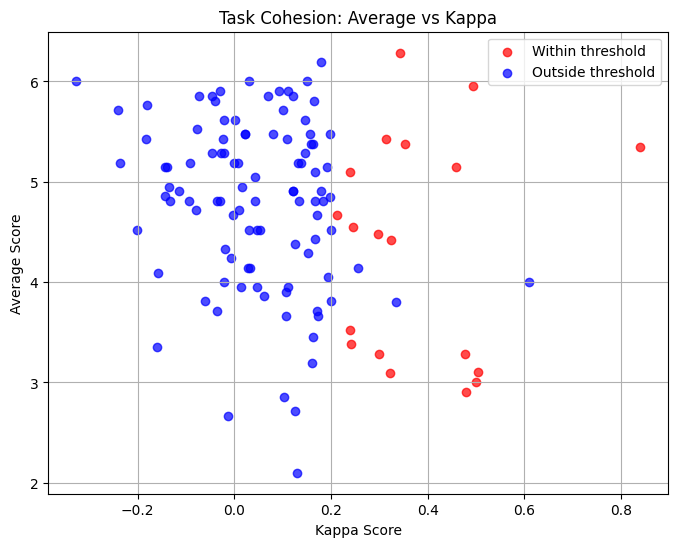

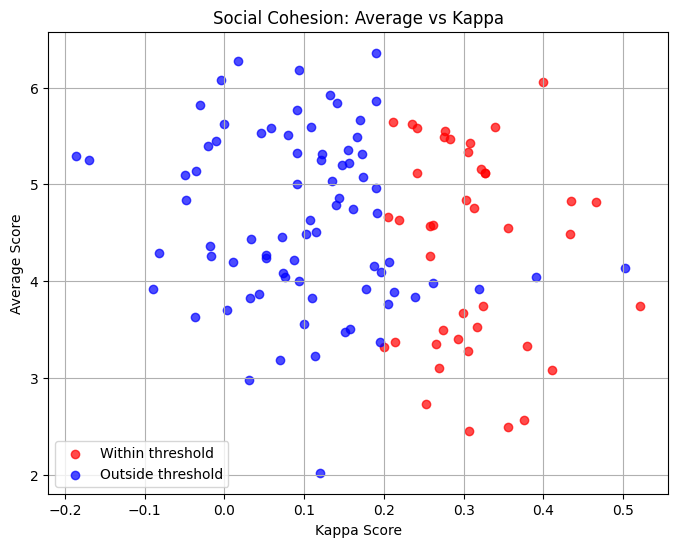

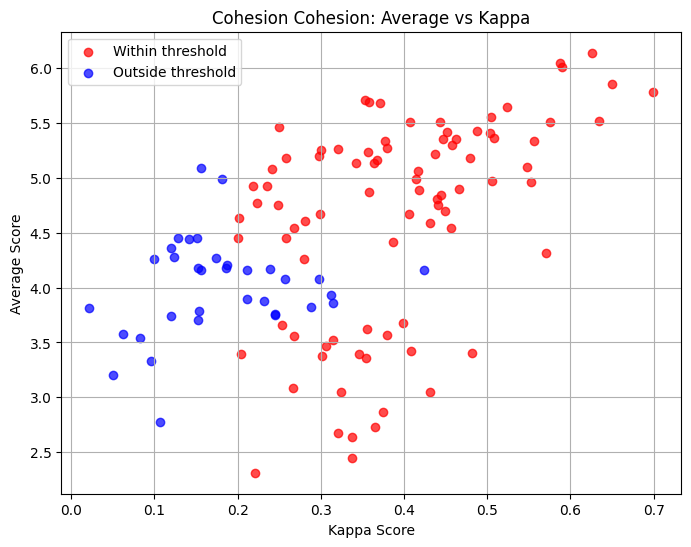

In [102]:
plot_kappa_vs_average(kappa_cohesion_df, 'Task', floor=4.25, ceiling=3.75, kappa_threshold=0.2)
plot_kappa_vs_average(kappa_cohesion_df, 'Social', floor=4.25, ceiling=3.75, kappa_threshold=0.2)
plot_kappa_vs_average(kappa_cohesion_df, 'Cohesion', floor=4.25, ceiling=3.75, kappa_threshold=0.2)

In [103]:
kappa_cohesion_df.to_pickle('/Users/manuelnunezmartinez/Documents/UF/Research Internship/code/Cohesion_Annotations/Cohesion_split_data.pkl')

For some reason we are only seeing a faint reprentation of the pattern found in the study, which found high kappa values to correlate with low or high means. This study found 61 sample that had a kappa score gerater than 0.3 which were nicely partitioned into high and low cohesion groups. I have found 10 which are not clearly seperated into two groups. This is a problem. 

Below we create a dataframe that allows for GNN binary prediction for each question: 

- Divide annotations by questions
- We impute missing values with averages 
- We invert the valence of certain question scores 
- We take the standard deviation and average of each annotation group for each question 
- The idea is to build a GNN model that takes the question number, a standard deviation threshold,a floor, and a ceiling. Using these parameters, two groups could be partitioned for binary level prediciton. 
- For example, if I chose question 4 (How is the morale of the team?), withe stanrad deviation of 1, floor of 4 and a cieling of 2, I would split the data into a high morale (above 4 average) and low morale (below 2 average), while only considering annotation groups that have a standard deviation below 1. This data parition could then be used to build a model. 

In [104]:
def split_cohesion_scores(df):
    def extract_question_ratings(column, prefix):
        """This function splits lists of annotator ratings by question."""
        max_questions = len(df[column].iloc[0][0])  
        question_columns = [f"{prefix}{i+1}" for i in range(max_questions)]
        
        question_data = {col: [] for col in question_columns}
        
        for entry in df[column]:
            for i in range(max_questions):
                question_data[f"{prefix}{i+1}"].append([entry[0][i], entry[1][i], entry[2][i]])  # Ratings from 3 annotators

        return pd.DataFrame(question_data)

    # Extract new columns for each type of cohesion
    task_df = extract_question_ratings('Task_Cohesion', 'T')
    social_df = extract_question_ratings('Social_Cohesion', 'S')
    misc_df = extract_question_ratings('Miscellaneous_Cohesion', 'M')
    
    # Concatenate the new columns
    df_new = pd.concat([df.drop(columns=['Cohesion', 'Task_Cohesion', 'Social_Cohesion', 'Miscellaneous_Cohesion']),
                        task_df, social_df, misc_df], axis=1)
    
    return df_new

In [105]:
questions_split_df = split_cohesion_scores(questions_split_df)
questions_split_df.head()

,Meeting,Start,End,T1,T2,T3,T4,T5,T6,T7,...,S11,S12,S13,S14,S15,S16,S17,M1,M2,M3
0,IS1006d,25.0,27.0,"[4.0, 1.0, 6.0]","[4.0, 2.0, 6.0]","[3.0, 1.0, 7.0]","[3.0, 2.0, 6.0]","[4.0, 1.0, 6.0]","[5.0, 4.0, 7.0]","[7.0, 2.0, 6.0]",...,"[6.0, 7.0, 7.0]","[5.0, 6.0, 6.0]","[7.0, 7.0, 7.0]","[5.0, 5.0, 6.0]","[5.0, 4.0, 6.0]","[5.0, 4.0, 6.0]","[6.0, 5.0, 9.0]","[2.0, 2.0, 2.0]","[9.0, 9.0, 9.0]","[6.0, 3.0, 7.0]"
1,IS1007b,1.0,3.0,"[2.0, 4.0, 5.0]","[-1.0, 4.0, 6.0]","[2.0, 2.0, 2.0]","[2.0, 4.0, 5.0]","[1.0, 2.0, 1.0]","[5.0, 3.0, 4.0]","[7.0, 7.0, 1.0]",...,"[-1.0, 2.0, 3.0]","[1.0, 3.0, 2.0]","[2.0, 3.0, 3.0]","[1.0, 3.0, 5.0]","[2.0, 1.0, 2.0]","[3.0, 2.0, 1.0]","[1.0, 3.0, 1.0]","[1.0, 1.0, 2.0]","[1.0, 3.0, 9.0]","[2.0, 2.0, 3.0]"
2,IS1003c,23.0,25.0,"[5.0, 2.0, 5.0]","[5.0, 3.0, 6.0]","[3.0, 4.0, 2.0]","[2.0, 3.0, 2.0]","[2.0, 3.0, 3.0]","[5.0, 3.0, 6.0]","[6.0, 4.0, 3.0]",...,"[5.0, 4.0, 4.0]","[1.0, 3.0, 4.0]","[3.0, 2.0, 5.0]","[2.0, 2.0, 3.0]","[3.0, 4.0, 3.0]","[4.0, 3.0, 5.0]","[2.0, 3.0, 5.0]","[2.0, 2.0, 1.0]","[9.0, 9.0, 9.0]","[3.0, 2.0, 4.0]"
3,IS1005c,8.0,10.0,"[3.0, 2.0, 1.0]","[3.0, -1.0, 5.0]","[4.0, 1.0, 4.0]","[3.0, 2.0, 2.0]","[3.0, 1.0, 1.0]","[1.0, 1.0, 2.0]","[1.0, 1.0, 1.0]",...,"[4.0, 2.0, 4.0]","[3.0, 2.0, 6.0]","[3.0, 4.0, 4.0]","[3.0, 1.0, 4.0]","[4.0, 2.0, 3.0]","[4.0, 1.0, 1.0]","[4.0, 2.0, 4.0]","[1.0, 1.0, 1.0]","[1.0, 9.0, 5.0]","[4.0, 9.0, 3.0]"
4,IS1001a,7.0,9.0,"[2.0, 4.0, 2.0]","[5.0, 5.0, 4.0]","[2.0, 2.0, 3.0]","[2.0, 2.0, 9.0]","[2.0, 2.0, 3.0]","[3.0, 4.0, 4.0]","[3.0, 1.0, 3.0]",...,"[5.0, 4.0, 4.0]","[4.0, 4.0, 3.0]","[4.0, 3.0, 6.0]","[3.0, 3.0, 3.0]","[5.0, 3.0, 4.0]","[3.0, 5.0, 4.0]","[5.0, 4.0, 4.0]","[1.0, 1.0, 1.0]","[5.0, 4.0, 4.0]","[4.0, 1.0, 3.0]"


We now add some descriptive statitsics ( computed ignoring -1s)

In [117]:
# Columns to exclude
exclude_columns = ['Meeting', 'Start', 'End']
stats_list = []

# Iterate through each column in the dataframe, excluding the specified ones
for column in questions_split_df.columns:
    if column not in exclude_columns:
        flat_values = [rating for sublist in questions_split_df[column] for rating in sublist]
        
        
        count_neg_ones = flat_values.count(9.0) 
        count_neg_ones += flat_values.count(-1.0)
        flat_values = [value for value in flat_values if value != -1.0 and value != 9.0]
        
        max_value = np.max(flat_values)
        min_value = np.min(flat_values)
        mean_value = np.mean(flat_values)
        std_dev = np.std(flat_values)
        num_unique_ratings = len(set(flat_values))  
        
        # Append the stats to the list
        stats_list.append({
            'Q': column,
            'Max': max_value,
            'Min': min_value,
            'Mean': mean_value,
            'Std Dev': std_dev,
            'Num -1s': count_neg_ones,
            'Num Unique Ratings': num_unique_ratings
        })


descriptive_stats_df = pd.DataFrame(stats_list)

add question to descriptive statistics 

In [118]:
file_path = "questions.txt"
questions_dict = {}

# Read the text file and extract the questions
with open(file_path, 'r') as file:
    lines = file.readlines()
    
    current_category = None  # This will track whether we're in Task, Social, or Miscellaneous
    
    for line in lines:
        line = line.strip()
        
        # Check for the category of cohesion
        if line == "Task cohesion":
            current_category = "T"
        elif line == "Social Cohesion":
            current_category = "S"
        elif line == "Miscellaneous":
            current_category = "M"
        
        elif line and current_category:
            question_number = line.split('.')[0]  # Get the number
            question_text = line.split('.', 1)[1].strip()
            question_key = f"{current_category}{question_number}"
            
            # Map the question key to the text
            questions_dict[question_key] = question_text

# Add a new column
descriptive_stats_df['Question'] = descriptive_stats_df['Q'].map(questions_dict)

In [119]:
descriptive_stats_df.head(27)

,Q,Max,Min,Mean,Std Dev,Num -1s,Num Unique Ratings,Question
0,T1,7.0,1.0,4.710306,1.621471,1,7,Does the team seem to share the responsibility...
1,T2,7.0,1.0,5.188202,1.305122,4,7,Do you feel that team members share the same p...
2,T3,7.0,1.0,4.403900,1.623671,1,7,"Overall, how enthusiastic is the group?"
3,T4,7.0,1.0,4.590909,1.421318,8,7,How is the morale of the team?
4,T5,7.0,1.0,4.513889,1.699616,0,7,"Overall, do the members give each other a lot ..."
5,T6,7.0,1.0,4.774373,1.532130,1,7,"Overall, do the team members appear to be coll..."
6,T7,7.0,1.0,4.905292,1.694477,1,7,Does every team member seem to have sufficient...
7,S1,7.0,1.0,4.977401,1.624164,6,7,"Overall, do you feel that the work group opera..."
8,S2,7.0,1.0,4.569444,1.704784,0,7,"Overall, how involved/engaged in the discussio..."
9,S3,7.0,1.0,4.702247,1.440231,4,7,Do the team members seem to enjoy each other's...


In [120]:
#compute mean and standard deviation for each list in the column
def calculate_mean_std(column_data):
    means = []
    stds = []
    for row in column_data:
        row_clean = [r for r in row if r != -1 and r != 9]
        means.append(np.mean(row_clean))  
        stds.append(np.std(row_clean))  
    return means, stds


list_columns = questions_split_df.columns[3:]

# Loop through each list column
for col in list_columns:
    mean_col_name = f'{col}_mean'
    std_col_name = f'{col}_std'
    
    means, stds = calculate_mean_std(questions_split_df[col])
    questions_split_df[mean_col_name] = means
    questions_split_df[std_col_name] = stds

questions_split_df.head()

/Users/manuelnunezmartinez/Documents/UF/Research Internship/code/transcriptionEnv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/manuelnunezmartinez/Documents/UF/Research Internship/code/transcriptionEnv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/manuelnunezmartinez/Documents/UF/Research Internship/code/transcriptionEnv/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/manuelnunezmartinez/Documents/UF/Research Internship/code/transcriptionEnv/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/manuelnunezmartinez/Documents/UF/Rese

,Meeting,Start,End,T1,T2,T3,T4,T5,T6,T7,...,S16_mean,S16_std,S17_mean,S17_std,M1_mean,M1_std,M2_mean,M2_std,M3_mean,M3_std
0,IS1006d,25.0,27.0,"[4.0, 1.0, 6.0]","[4.0, 2.0, 6.0]","[3.0, 1.0, 7.0]","[3.0, 2.0, 6.0]","[4.0, 1.0, 6.0]","[5.0, 4.0, 7.0]","[7.0, 2.0, 6.0]",...,5.0,0.816497,5.500000,0.500000,2.000000,0.000000,NaN,NaN,5.333333,1.699673
1,IS1007b,1.0,3.0,"[2.0, 4.0, 5.0]","[-1.0, 4.0, 6.0]","[2.0, 2.0, 2.0]","[2.0, 4.0, 5.0]","[1.0, 2.0, 1.0]","[5.0, 3.0, 4.0]","[7.0, 7.0, 1.0]",...,2.0,0.816497,1.666667,0.942809,1.333333,0.471405,2.000000,1.000000,2.333333,0.471405
2,IS1003c,23.0,25.0,"[5.0, 2.0, 5.0]","[5.0, 3.0, 6.0]","[3.0, 4.0, 2.0]","[2.0, 3.0, 2.0]","[2.0, 3.0, 3.0]","[5.0, 3.0, 6.0]","[6.0, 4.0, 3.0]",...,4.0,0.816497,3.333333,1.247219,1.666667,0.471405,NaN,NaN,3.000000,0.816497
3,IS1005c,8.0,10.0,"[3.0, 2.0, 1.0]","[3.0, -1.0, 5.0]","[4.0, 1.0, 4.0]","[3.0, 2.0, 2.0]","[3.0, 1.0, 1.0]","[1.0, 1.0, 2.0]","[1.0, 1.0, 1.0]",...,2.0,1.414214,3.333333,0.942809,1.000000,0.000000,3.000000,2.000000,3.500000,0.500000
4,IS1001a,7.0,9.0,"[2.0, 4.0, 2.0]","[5.0, 5.0, 4.0]","[2.0, 2.0, 3.0]","[2.0, 2.0, 9.0]","[2.0, 2.0, 3.0]","[3.0, 4.0, 4.0]","[3.0, 1.0, 3.0]",...,4.0,0.816497,4.333333,0.471405,1.000000,0.000000,4.333333,0.471405,2.666667,1.247219


In [121]:
def count_acceptable_rows(df, ceiling, floor, max_std):
    results = []
    
    # Iterate over the mean and std columns, assuming the format: T1_mean, T1_std, etc.
    for col in df.columns:
        if col.endswith('_mean'):  # Only process mean columns
            question = col.replace('_mean', '')  # Get the base question name (T1, T2, etc.)
            std_col = question + '_std'  # Find the corresponding std column
            
            # Count the number of rows that meet the conditions
            acceptable_rows = df[((df[col] >= floor) | (df[col] <= ceiling)) & (df[std_col] <= max_std)].shape[0]
            
            # Store the result for this question
            results.append({'Question': question, 'Acceptable Rows': acceptable_rows})
    
    # Convert results to a DataFrame for better display
    result_df = pd.DataFrame(results)
    return result_df

In [122]:
threshold_ceiling = 3.0
threshold_floor = 5.0
max_std_dev = 1.5

acceptable_rows_df = count_acceptable_rows(questions_split_df, ceiling=threshold_ceiling, floor=threshold_floor, max_std=max_std_dev)
acceptable_rows_df.head(27)

,Question,Acceptable Rows
0,T1,67
1,T2,75
2,T3,63
3,T4,64
4,T5,81
5,T6,65
6,T7,70
7,S1,71
8,S2,74
9,S3,60


In [123]:
def plot_std_vs_mean(df, question_name, jitter_strength=0.02, floor=5, ceiling=3, max_std=1.0):
    mean_col = question_name + '_mean'
    std_col = question_name + '_std'
    
    if mean_col in df.columns and std_col in df.columns:
        means = df[mean_col]
        stds = df[std_col]
        
        # Apply jitter by adding random noise
        jitter_means = means + np.random.normal(0, jitter_strength, size=len(means))
        jitter_stds = stds + np.random.normal(0, jitter_strength, size=len(stds))
        
        within_threshold = ((jitter_means >= floor) | (jitter_means <= ceiling)) & (jitter_stds <= max_std)
        
        # Plot points outside the thresholds
        plt.figure(figsize=(8, 6))
        plt.scatter(jitter_means[~within_threshold], jitter_stds[~within_threshold], color='blue', alpha=0.7, label='Outside thresholds')
        
        # Plot points within the thresholds with a different color
        plt.scatter(jitter_means[within_threshold], jitter_stds[within_threshold], color='red', alpha=0.7, label='Within thresholds')

        # Plot settings
        plt.title(f'Standard Deviation vs Mean for {question_name} (with Jitter)')
        plt.xlabel('Mean')
        plt.ylabel('Standard Deviation')
        plt.grid(True)
        plt.legend()
        plt.show()
    else:
        print(f"Question '{question_name}' not found in the DataFrame.")

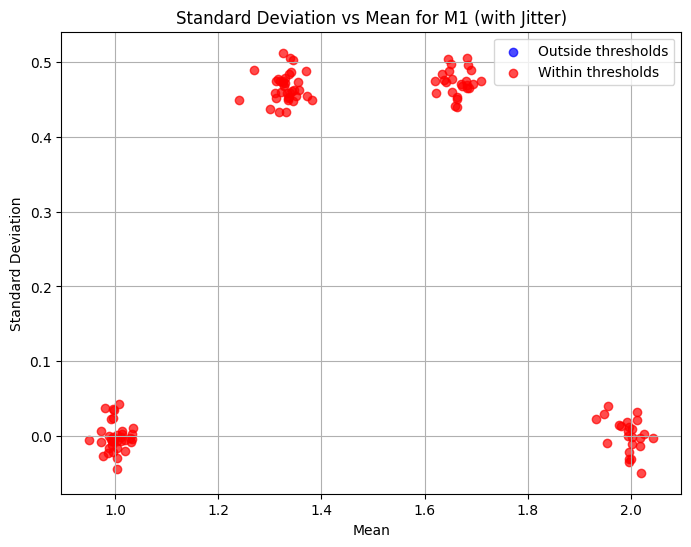

In [149]:
plot_std_vs_mean(questions_split_df, 'M1', floor = 4.5, ceiling=3.5, max_std=1.5)

Lets now save these data frames

In [125]:
questions_split_df.to_pickle('/Users/manuelnunezmartinez/Documents/UF/Research Internship/code/Cohesion_Annotations/Question_Split_data.pkl')
descriptive_stats_df.to_pickle('/Users/manuelnunezmartinez/Documents/UF/Research Internship/code/Cohesion_Annotations/Question_Split_Des_data.pkl')

Ok this is all looking pretty prmising now. Lets fix the current pkl where graph info for these meetings is being stored and then we can actually move onto MODELLLING!!!! 

In [127]:
import pickle 

with open('/Users/manuelnunezmartinez/Documents/UF/Research Internship/code/GNNs/graphs_cohesion_data.pkl', 'rb') as f:
    graphs_cohesion_data = pickle.load(f)

In [131]:
# Loop through each entry and remove 'social', 'task', and 'misc' keys
for entry in graphs_cohesion_data:
    entry.pop('social', None)  
    entry.pop('task', None)    
    entry.pop('misc', None)  

print(len(graphs_cohesion_data))

100


In [133]:
print(graphs_cohesion_data[0])

{'meeting': 'IS1000a', 'start': 1200.0, 'features': ({'A': [('time_portion', 0.06187262028383593), ('speaking_turns_proportion', 0.0), ('rate_of_speech', 5.594405594405523), ('lexical_richness', 0.25), ('positive_sentiment_proportion', 0.0), ('negative_sentiment_proportion', 0.0), ('average_word_rarity', 7.391125e-05), ('first_person_pronoun_usage', 0.0), ('second_person_pronoun_usage', 0.0), ('third_person_pronoun_usage', 0.0), ('agreement_words_proportion', 0.0), ('disagreement_words_proportion', 0.0)], 'B': [('time_portion', 0.3065939771547229), ('speaking_turns_proportion', 0.2), ('rate_of_speech', 3.302286198137187), ('lexical_richness', 0.6410256410256411), ('positive_sentiment_proportion', 0.030303030303030304), ('negative_sentiment_proportion', 0.0), ('average_word_rarity', 0.00017957676363636362), ('first_person_pronoun_usage', 0.0), ('second_person_pronoun_usage', 0.02564102564102564), ('third_person_pronoun_usage', 0.0), ('agreement_words_proportion', 0.08547008547008547), (

In [132]:
import pickle

# Assuming 'graphs' is your list of graph data
with open('/Users/manuelnunezmartinez/Documents/UF/Research Internship/code/GNNs/annotations_graphs_new.pkl', 'wb') as f:
    pickle.dump(graphs_cohesion_data, f)

In [136]:
kappa_cohesion_df.head()

,Meeting,Start,End,Cohesion,Task_Cohesion,Social_Cohesion,Miscellaneous_Cohesion,Task_Kappa,Social_Kappa,Cohesion_Kappa,Task_Average,Social_Average,Cohesion_Average
0,IS1006d,25.0,27.0,"[[5.0, 4.0, 4.0, 3.0, 5.0, 6.0, 3.0, 4.0, 5.0,...","[[4.0, 4.0, 3.0, 3.0, 4.0, 5.0, 7.0], [1.0, 2....","[[5.0, 5.0, 6.0, 5.0, 7.0, 5.0, 6.0, 5.0, 5.0,...","[[2.0, 9.0, 6.0], [2.0, 9.0, 3.0], [2.0, 9.0, ...",0.033335,0.140622,0.298247,4.142857,5.836735,5.197368
1,IS1007b,1.0,3.0,"[[5.0, 2.0, -1.0, 2.0, 2.0, 3.0, 2.0, 1.0, 2.0...","[[2.0, -1.0, 2.0, 2.0, 1.0, 5.0, 7.0], [4.0, 4...","[[5.0, 2.0, 3.0, 2.0, 5.0, 2.0, 1.0, 9.0, 2.0,...","[[1.0, 1.0, 2.0], [1.0, 3.0, 2.0], [2.0, 9.0, ...",0.162190,0.355717,0.320634,3.450000,2.489796,2.675325
2,IS1003c,23.0,25.0,"[[6.0, 5.0, 5.0, 3.0, 3.0, 4.0, 2.0, 2.0, 4.0,...","[[5.0, 5.0, 3.0, 2.0, 2.0, 5.0, 6.0], [2.0, 3....","[[6.0, 3.0, 4.0, 4.0, 3.0, 5.0, 3.0, 3.0, 4.0,...","[[2.0, 9.0, 3.0], [2.0, 9.0, 2.0], [1.0, 9.0, ...",0.107829,-0.036448,0.082340,3.666667,3.627451,3.538462
3,IS1005c,8.0,10.0,"[[3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 4.0,...","[[3.0, 3.0, 4.0, 3.0, 3.0, 1.0, 1.0], [2.0, -1...","[[3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 1.0, 5.0, 2.0,...","[[1.0, 1.0, 4.0], [1.0, 9.0, 9.0], [1.0, 5.0, ...",0.129785,0.306105,0.375170,2.100000,3.276596,2.864865
4,IS1001a,7.0,9.0,"[[5.0, 2.0, 5.0, 2.0, 4.0, 4.0, 2.0, 2.0, 2.0,...","[[2.0, 5.0, 2.0, 2.0, 2.0, 3.0, 3.0], [4.0, 5....","[[5.0, 4.0, 4.0, 2.0, 6.0, 4.0, 2.0, 5.0, 3.0,...","[[1.0, 5.0, 4.0], [1.0, 4.0, 1.0], [1.0, 4.0, ...",0.479670,0.324020,0.481775,2.900000,3.740000,3.405063


In [146]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_cohesion_progression(df):
    meetings = df['Meeting'].unique()

    # Increase figure size
    plt.figure(figsize=(12, 8))  # Width=12, Height=8

    # Loop over each meeting to plot its progression
    for meeting in meetings:
        meeting_df = df[(df['Meeting'] == meeting) & (df['Cohesion_Kappa'] > 0.25)]

        # Calculate midpoint for each time interval
        meeting_df['Midpoint'] = (meeting_df['Start'] + meeting_df['End']) / 2

        # Sort by midpoint (time progression)
        meeting_df = meeting_df.sort_values(by='Midpoint')

        # Plot the Midpoint against Cohesion_Average
        plt.plot(meeting_df['Midpoint'], meeting_df['Cohesion_Average'], marker='o', label=f'{meeting}')

    # Customize the plot
    plt.title('Progression of Cohesion Over Time for Each Meeting')
    plt.xlabel('Time (Minutes)')
    plt.ylabel('Cohesion Average')
    plt.legend()
    plt.grid(True)
    plt.show()


/var/folders/r_/wwpxjnln7vx4bw2q6dxn_svm0000gn/T/ipykernel_51587/1918296793.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meeting_df['Midpoint'] = (meeting_df['Start'] + meeting_df['End']) / 2
/var/folders/r_/wwpxjnln7vx4bw2q6dxn_svm0000gn/T/ipykernel_51587/1918296793.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meeting_df['Midpoint'] = (meeting_df['Start'] + meeting_df['End']) / 2
/var/folders/r_/wwpxjnln7vx4bw2q6dxn_svm0000gn/T/ipykernel_51587/1918296793.py:15: SettingWithCopyWarning: 
A va

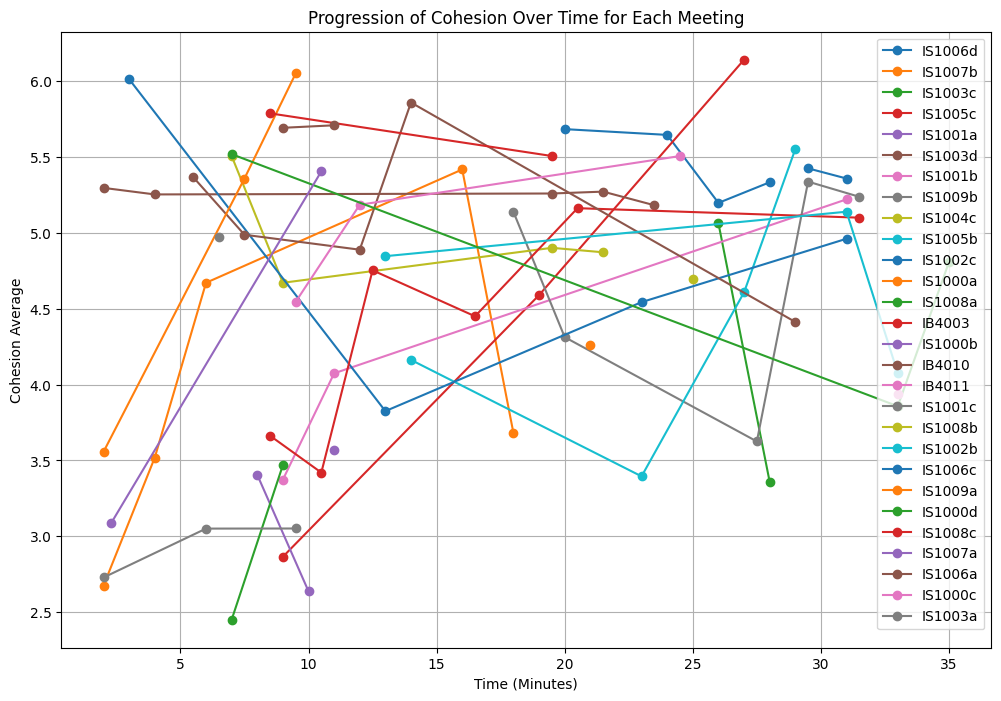

In [147]:
plot_cohesion_progression(kappa_cohesion_df)